In [1]:
import os
from ultralytics import SAM
# import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
from PIL import Image
from ultralytics.data.utils import visualize_image_annotations

In [2]:
# Class folders should be organized as follows:
#
# raw/
# └── screwdriver_kaggle/
#    ├── screwdriver/
#    │   ├── images/
#    │   │   ├── 1.jpg
#    │   │   └── ...
#    │   ├── labels/
#    │   │   ├── 1.txt
#    │   │   └── ...
#    │   ├── masks/
#    │   │   ├── 1_mask.png
#    │   │   └── ...  
#    ├── hammer/
#    │   └── .../
#    ├── .../
#    └── classes.txt

# Darknet files should have the following format:
# class_index x_center y_center width height
#
# e.g.
# 0 0.5 0.5 0.2 0.2

# classes.txt should contain the class names, one per line:
# e.g.
# screwdriver
# hammer
# ...

raw_dataset_name = 'kaggle_v0'
cnp_output_name = 'cut_and_paste_root2'
output_dataset_name = 'cut_and_paste_vik_test'
object_classes = ['screwdriver', 'hammer']
class_dirs = [f'/home/data/raw/{raw_dataset_name}/{object_class}/' for object_class in object_classes]
output_dirs = class_dirs
# output_dirs = [f'/home/data/raw/{raw_dataset_name}/{cnp_output_name}/{object_class}/' for object_class in object_classes]
# output_dirs = [f'/home/data/raw/{project_name}/{object_class}/' for object_class in object_classes]


In [ ]:
def resize_images(input_dir, output_dir, size=(640//3, 480//3)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for img_file in glob.glob(os.path.join(input_dir, '*.jpg')):
        img = Image.open(img_file)
        img = img.resize(size, Image.LANCZOS)
        img.save(os.path.join(output_dir, os.path.basename(img_file)))

In [ ]:
# for class_dir in class_dirs:
#     resize_images(os.path.join(class_dir, 'images'), os.path.join(class_dir, 'images_resized'))

In [ ]:
def read_darknet_bboxes(bbox_path, image_width, image_height):
	"""Read bounding boxes from darknet format file and convert to pixel coordinates"""
	bboxes = []
	
	with open(bbox_path, 'r') as f:
		for line in f:
			parts = line.strip().split()
			assert len(parts) == 5, f"Invalid bbox line: {line.strip()}"
			
			# Darknet format: class_id x_center y_center width height (normalized)
			class_id = int(parts[0])
			x_center = float(parts[1])
			y_center = float(parts[2])
			width = float(parts[3])
			height = float(parts[4])
			
			# Convert from normalized coordinates to pixel coordinates
			x_center_px = x_center * image_width
			y_center_px = y_center * image_height
			width_px = width * image_width
			height_px = height * image_height
			
			# Convert to x1, y1, x2, y2 format
			x1 = int(x_center_px - width_px / 2)
			y1 = int(y_center_px - height_px / 2)
			x2 = int(x_center_px + width_px / 2)
			y2 = int(y_center_px + height_px / 2)
			
			# Ensure coordinates are within image bounds
			x1 = max(0, min(x1, image_width - 1))
			y1 = max(0, min(y1, image_height - 1))
			x2 = max(0, min(x2, image_width - 1))
			y2 = max(0, min(y2, image_height - 1))
			
			bboxes.append([x1, y1, x2, y2])

	return bboxes

def segment_images_from_folder_bbox(class_dir, output_dir):
    """
    Segments images in the specified folder using the SAM model with bbox information.
    Assumes class_dir contains two folders: 'images_resized' and 'labels'.
    Each image in 'images_resized' should have a corresponding label file in 'labels' with
    bounding box information in the format: x y w h (where x, y are the
    top-left corner coordinates and w, h are the width and height of the bounding box).
    """
    model = SAM("sam2.1_l.pt")

    for image_path, bbox_path in list(zip(sorted(glob.glob(os.path.join(class_dir, 'images', '*'))), 
                                          sorted(glob.glob(os.path.join(class_dir, 'labels', '*.txt'))))):
        image_dimensions = cv2.imread(image_path).shape
        bboxes = read_darknet_bboxes(bbox_path, image_dimensions[1], image_dimensions[0])
        
        # Predict segmentation using the SAM model with bounding box
        results = model(image_path, bboxes=bboxes)
        # visualize_image_annotations(image_path, bbox_path, output_dir)
        for result in results:
            # Access the masks
            masks = results[0].masks

            # Assuming single class segmentation for simplicity, adjust as needed
            mask = masks[0].data.squeeze().cpu().numpy()  # For multi-class, iterate over masks
            mask = mask.astype(np.uint8) # Convert mask to uint8 if needed)
            mask = cv2.resize(mask, (image_dimensions[1], image_dimensions[0]))
            
            image = cv2.imread(image_path)
            image = cv2.resize(image, (image_dimensions[1], image_dimensions[0]))
            
            # Negate the mask and mask the image
            negative_mask = 1-mask
            negative_image = cv2.bitwise_not(image)
            negative_image = cv2.bitwise_and(negative_image, negative_image, mask=mask)
            masked_image = cv2.bitwise_not(negative_image)
            
            # Uncomment to see the negated masks
            # plt.imshow(negative_mask, cmap='gray')
            # plt.axis('off')
            # plt.show()

            # Uncomment to plot the masked images
            # plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
            # plt.axis('off')
            # plt.show()

            os.mkdir(output_dir) if not os.path.exists(output_dir) else None
            for subdir in ['images', 'masks', 'labels']:
            # Create subdirectories if they do not exist
                subdir_path = os.path.join(output_dir, subdir)
                if not os.path.exists(subdir_path): 
                    os.mkdir(subdir_path)
                    
            cv2.imwrite(os.path.join(output_dir, 'masks', os.path.basename(image_path).split('.')[0] + '_mask.png'), negative_mask*255)


In [ ]:
# if not os.path.exists(f'/home/data/raw/{raw_dataset_name}/{cnp_output_name}/'):
#     os.mkdir(f'/home/data/raw/{raw_dataset_name}/{cnp_output_name}')

# os.system(f"cp /home/data/raw/{raw_dataset_name}/classes.txt /home/data/raw/{raw_dataset_name}/{cnp_output_name}/")

for class_dir, output_dir in list(zip(class_dirs, output_dirs)):
	segment_images_from_folder_bbox(class_dir, output_dir)

In [ ]:
os.system(f'python Cut-and-Paste/dataset_generator.py --scale --rotation --num 1 /home/data/raw/{raw_dataset_name}/ /home/data/processed/{raw_dataset_name}/{output_dataset_name}')

In [3]:
from pietorch import blend
import torch
import matplotlib.pyplot as plt

In [4]:
from PIL import Image
from torchvision.transforms import functional as TF

In [5]:
target_tensor = torch.load('target_tensor.pt')
source_tensor = torch.load('source_tensor.pt')
mask_tensor = torch.load('mask_tensor.pt')
background_array = torch.load('background_array.pt')

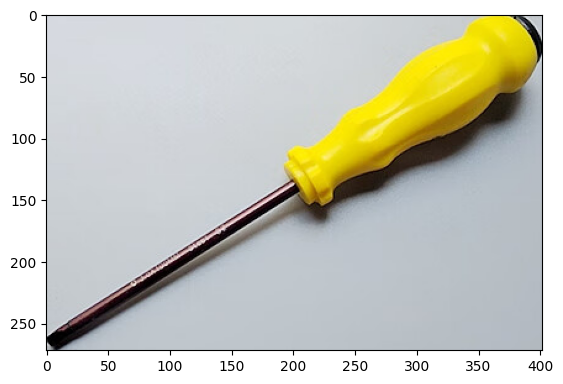

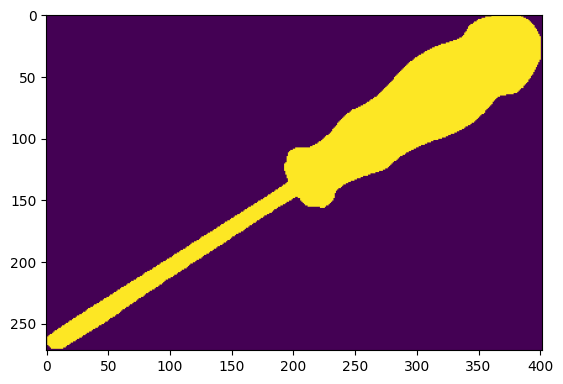

In [6]:
plt.imshow(source_tensor)
plt.show()
plt.imshow(mask_tensor)
plt.show()

In [9]:
# target_tensor = TF.to_tensor(synth_images[i]).permute(1,2,0)
# source_tensor = TF.to_tensor(foreground).permute(1,2,0)
# mask_tensor = TF.to_tensor(mask).squeeze(0) #PIL2array1C(mask)
# source_tensor, mask_tensor, offset_adj = trim_mask(target_tensor, source_tensor, mask_tensor, offset)
# offset_adj = torch.tensor(offset_adj[::-1])
# print(offset_adj)
offset_adj = torch.tensor([135, 345])

img_1 = Image.open('/home/data/raw/backgrounds/bg-20k/BG-20k/train/h_0a0c92d7.jpg')
target_tensor_manual = TF.to_tensor(img_1).permute(1,2,0)

background_array = blend(target_tensor_manual, source_tensor, mask_tensor, offset_adj, False, channels_dim=2)

result = Image.fromarray((background_array.numpy()*255).astype(np.uint8), 'RGB')

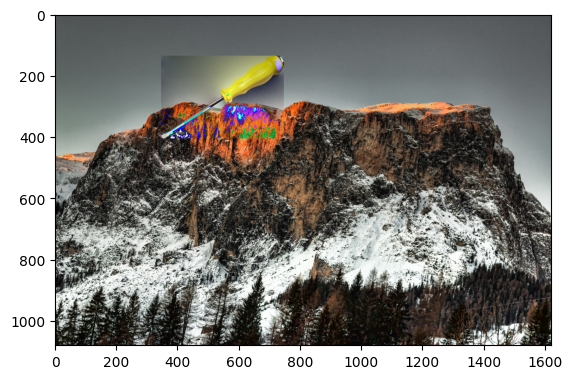

In [10]:
plt.imshow(result)

In [ ]:
background_array.min()

In [ ]:
background_array -= background_array.min()
background_array /= background_array.max()
plt.imshow(background_array.numpy())
plt.show()
plt.imshow(Image.fromarray((background_array.numpy()*255).astype(np.uint8), 'RGB'))
plt.show()

In [ ]:
os.system(f'python -m cProfile -o results.prof Cut-and-Paste/dataset_generator.py --scale --rotation --num 1 /home/data/raw/{raw_dataset_name}/ /home/data/processed/{raw_dataset_name}/{output_dataset_name}')

In [ ]:
os.system("""python -c "import pstats; p = pstats.Stats('results.prof'); p.sort_stats('cumulative').print_stats()" > output.txt""")

In [ ]:
print(cv2.imread('/home//data/processed/screwdriver_kaggle/{output_dataset_name}/train/images/1_box.jpg').shape)

In [ ]:
# img_1 = Image.open('/home/data/raw/backgrounds/bg-20k/BG-20k/train/h_0a0c92d7.jpg')
img_1 = Image.open('/home/data/raw/backgrounds/indoorCVPR_09_images/arton447_ba6a0.jpg')
img_1 = img_1.resize((640*4, 480*4), Image.LANCZOS)
target = TF.to_tensor(img_1).transpose(0,2).transpose(0,1)

# img_path = '/home/data/raw/kaggle_v0/hammer/images/0a89821a-211e2d2f-45eb-451d-9885-dfc3b07e2bf9.jpg'
img_path = '/home/data/raw/kaggle_v0/screwdriver/images/35f643d3-f6373cbc-ab88-454f-b386-e0843be187b4.jpeg'
source = Image.open(img_path)
# resize source image to be smaller
resized_dims = (target.shape[1]//3, target.shape[0]//3)
source = source.resize(resized_dims, Image.LANCZOS)
source = TF.to_tensor(source).transpose(0,2).transpose(0,1)

mask_img = Image.open(img_path.replace('.jpg', '_mask.png').replace('.jpeg', '_mask.png').replace('/images','/masks'))
mask_img = mask_img.resize(resized_dims, Image.LANCZOS)
mask = TF.to_tensor(mask_img).squeeze(0)
mask = (1-mask)  # Invert mask and normalize to [0, 1]
# plt.imshow(mask)

corner = torch.tensor([150,100])

print('Blending images with shapes:', target.shape, source.shape, mask.shape)

result = blend(target, source, mask, corner, False, channels_dim=2, )

In [ ]:
#imshow the result image in a 12x8 inches figure
plt.figure(figsize=(12, 8))
plt.imshow(result)
plt.axis('off')
